In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
leaf = pd.read_csv('/content/drive/MyDrive/grow_vision/leaf_area.csv')
leaf = leaf.drop(['Unnamed: 0', 'path'], axis=1)

data = pd.read_csv('/content/drive/MyDrive/grow_vision/predict_leaf_area.csv')
data = data.drop(['Unnamed: 0'], axis=1)

# масштаб
data['0'] = data['0'] / (384 * 384) * 160 * 190

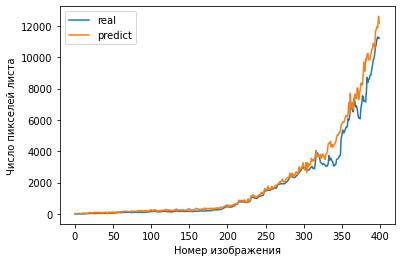

In [ ]:
plt.plot(data)
plt.plot(leaf)

plt.ylabel('Число пикселей листа')
plt.xlabel('Номер изображения')
plt.legend(['real', 'predict'])
plt.show()

In [ ]:
# для воспроизводимости результатов
np.random.seed(42)

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test

In [ ]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [ ]:
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

In [ ]:
n_lag = 3
n_seq = 3
n_test = 100

scaler, train, test = prepare_data(data, n_test, n_lag, n_seq)

print('Train: %s, Test: %s' % (train.shape, test.shape))

Train: (294, 6), Test: (100, 6)


In [ ]:
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
 
	# fit network
	for i in tqdm(range(nb_epoch)):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

def fit_gru(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(GRU(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
 
	# fit network
	for i in tqdm(range(nb_epoch)):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [ ]:
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

In [ ]:
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [ ]:
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

In [ ]:
def inverse_transform(series, forecasts, scaler, n_test):
    
    inverted = list()
    for i in range(len(forecasts)):
      # create array from forecast
      
      forecast = np.array(forecasts[i])
      forecast = forecast.reshape(1, len(forecast))
      # invert scaling
      inv_scale = scaler.inverse_transform(forecast)
      inv_scale = inv_scale[0, :]
      # invert differencing
      index = len(series) - n_test + i - 1
      last_ob = series.values[index]
      inv_diff = inverse_difference(last_ob, inv_scale)
      # store
      inverted.append(inv_diff)
    return inverted

In [ ]:
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	plt.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		plt.plot(xaxis[:20], yaxis[:20], color='red')

### LSTM

In [1]:
from keras_tqdm import TQDMNotebookCallback

ModuleNotFoundError: ignored

In [ ]:
n_batch = 1
nb_epoch = 100
n_neurons = 1
model = fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)

In [ ]:
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts = inverse_transform(data, forecasts, scaler, n_test+3)

In [ ]:
actual = [row[n_lag:] for row in test]
actual = inverse_transform(data, actual, scaler, n_test+3)

In [ ]:
len(actual)

In [ ]:
plot_forecasts(data, forecasts, n_test+3)

In [ ]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
  for i in range(n_seq):
    actual = [row[i] for row in test]
    predicted = [forecast[i] for forecast in forecasts]
    print(actual)
    print(pred)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print('t+%d RMSE: %f' % ((i+1), rmse))

In [ ]:
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

In [ ]:
#LSTM

results_1 = np.array([26.6, 0, 0, 0]) / 484
results_2 = np.array([26.6, 39.8, 0, 0]) / 484
results_3 = np.array([27.8, 41.8, 54.7, 0]) / 484
results_4 = np.array([27.1, 40.4, 52.1, 63.5])/ 484

In [ ]:
fig, ax = plt.subplots()
labels = [1, 2, 3, 4]

ax.set_ylabel('Ошибка, см^2')
ax.set_xlabel('Временной шаг, ед.')
ax.set_title('Ошибка при прогнозировании LSTM')
x = np.arange(len(results_3))  # the label locations
width = 0.5
ax.bar(x - width, results_1, width/2, label='1')
ax.bar(x - width/2, results_2, width/2, label='2', color='skyblue')
ax.bar(x, results_3, width/2, label='3', color='gold')
ax.bar(x + width/2, results_4, width/2, label='4', color='seagreen')
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()

In [ ]:
#GRU

results_1 = np.array([21.2, 0, 0, 0]) / 484
results_2 = np.array([20.7, 23.4, 0, 0]) / 484
results_3 = np.array([21.4, 25.4, 34.5, 0]) / 484
results_4 = np.array([21.4, 24.3, 34.8, 40.5])/ 484

In [ ]:
fig, ax = plt.subplots()
labels = [1, 2, 3, 4]

ax.set_ylabel('Ошибка, см^2')
ax.set_xlabel('Временной шаг, ед.')
ax.set_title('Ошибка при прогнозировании GRU')
x = np.arange(len(results_3))  # the label locations
width = 0.5
ax.bar(x - width, results_1, width/2, label='1')
ax.bar(x - width/2, results_2, width/2, label='2', color='skyblue')
ax.bar(x, results_3, width/2, label='3', color='gold')
ax.bar(x + width/2, results_4, width/2, label='4', color='seagreen')
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()